In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import signal as sig
from scipy.interpolate import interp1d as intpo
from scipy.fftpack import fft
import control
from control.matlab import *
import os
import sys
import math
import random

![title](img/htw_cr.png)

Input: 
- Polynom
- Grad maximal 6

Output: 
- Nullstellen
- Polstellen
- Systemübertragungsfunktion
- Phasengang

Notes:

- Notebook als Tutorial
- Abgabe 31.05.2020

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

%pylab inline
import seaborn as sns
from tqdm.notebook import tqdm as tqdm
from ipywidgets import IntProgress

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['place', 'unwrap', 'append', 'fft', 'connect', 'random', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import multiprocessing
random.seed(44)

Basic System Elements

![title](img/linearitaet_system.png)

Spezielle diskrete LTI-Systeme

![title](img/tapped_delay_line_direktform_FIR.png)

In [4]:
class LTI_FIR_Sys(object):
    '''klassisches FIR system'''
    amount_of_coef = 0
    coef_list = []
    amount_delay_elements = 0
    delay_list = []
    fir_list = []
    finite_impulse_response = []
    transfer_function = []
    transfer_function_frey = []
    class DelayElement(object):
        new_input = 0
        output_value = 0
        is_integrated_in_processing_chain = False
        def __init__(self):
            print("Delay element created.")
        def get_output(self):
            return self.output_value
        def update_input(self, new_value_passed):
            self.new_input = new_value_passed
        def update_output(self, new_value_passed):
            self.output_value = new_value_passed
        def get_processing_flag(self):
            return self.is_integrated_in_processing_chain
        def set_integration_flag(self, passed_flag):           
            self.is_integrated_in_processing_chain = passed_flag
        
    def __init__(self, initial_coef_list):
        #print("under construction")
        self.amount_of_coef = len(initial_coef_list)
        self.coef_list = initial_coef_list
        self.amount_delay_elements = len(initial_coef_list) - 1
        for i in range(self.amount_delay_elements):
            created_delay_element = self.DelayElement()
            self.delay_list.append(created_delay_element)
    
    def update_delays_elements(self, new_starting_chainvalue):
        #print("under construction")
        temp_even = 0
        temp_odd = 0
        for i in range(self.amount_delay_elements):       
            if i == 0:
                temp_odd = self.delay_list[i].get_output()
                self.delay_list[i].update_input(new_starting_chainvalue)
                self.delay_list[i].update_output(new_starting_chainvalue)                
                if self.delay_list[i].get_processing_flag() == False:
                    self.delay_list[i].set_integration_flag(True)
                    break
            elif (i > 0) and (i <=1) and (i % 2 > 0):
                temp_even = self.delay_list[i].get_output()
                self.delay_list[i].update_input(temp_odd)
                self.delay_list[i].update_output(temp_odd)
                if self.delay_list[i].get_processing_flag() == False:
                    self.delay_list[i].set_integration_flag(True)
                    break
            elif (i > 1) and (i % 2 == 0):
                temp_odd = self.delay_list[i].get_output()
                self.delay_list[i].update_input(temp_even)
                self.delay_list[i].update_output(temp_even)
                if self.delay_list[i].get_processing_flag() == False:
                    self.delay_list[i].set_integration_flag(True)
                    break
            elif (i > 1) and (i % 2 > 0):
                temp_even = self.delay_list[i].get_output()
                self.delay_list[i].update_input(temp_odd)
                self.delay_list[i].update_output(temp_odd)
                if self.delay_list[i].get_processing_flag() == False:
                    self.delay_list[i].set_integration_flag(True)
                    break                                            
                
    def calculate_finite_impulse_response(self, passed_signal):
        '''pas a signal in argument in form of a list'''
        #print("under construction")
        lengh_signal = len(passed_signal)   
        loop_lengh = lengh_signal + self.amount_delay_elements
        #print(loop_lengh)
        #generate new adjusted input signal
        adjusted_input_signal = []
        for i in range(loop_lengh):
            if i <= (lengh_signal - 1):
                adjusted_input_signal.append(passed_signal[i])
            else:
                adjusted_input_signal.append(0)
        #print("adjusted input signal: {}".format(adjusted_input_signal))
        #pass the signal through the system
        integration_counter_flag = False
        for process_index in range(loop_lengh):            
            time_sum_value = 0
            if process_index > self.amount_delay_elements:
                integration_counter_flag = True
            for i in range(len(self.coef_list)):
                if i == 0:
                    time_sum_value += self.coef_list[i] * adjusted_input_signal[process_index]
                else:
                    #for delay_index in range(self.amount_delay_elements):
                    temp_output_delay = self.delay_list[i-1].get_output()
                    #print(temp_output_delay)
                    #print("mal")
                    #print(self.coef_list[i])
                    #print("ergebnis: {}".format(self.coef_list[i]*temp_output_delay))
                    time_sum_value += self.coef_list[i] * self.delay_list[i-1].get_output()         
            self.finite_impulse_response.append(time_sum_value)
            #update the delay elements
            #print("outsourced in other function")
            self.update_delays_elements(adjusted_input_signal[process_index])
    
    def mean(self, signal, n):
        '''first input argument is the signal in form of a list'''
        '''second argument is the gliding mean value kernel n as positive integer this value has to be an odd number'''
        '''the return value is a list of a mean of the input signal'''
        signal_length = len(signal)
        loop_range_helper_coefs = 2*(n) - 1
        loop_range = signal_length + n - 1
        output_mean_signal = []
        #initialize output signal
        zero_buffer_adjusted = False
        signal_is_implemented = False
        counter_zero_buffer = 0
        #create helper array for Xk coeffs
        helper_coefs = []
        for i in range(loop_range_helper_coefs):
            if (counter_zero_buffer < (n)) and (zero_buffer_adjusted == False):
                counter_zero_buffer += 1
                helper_coefs.append(0)
                if counter_zero_buffer == (n-1):
                    zero_buffer_adjusted = True
                    continue
            if (zero_buffer_adjusted == True) and (counter_zero_buffer == n - 1):
                for x in range(signal_length):
                    helper_coefs.append(signal[x])                
                    counter_zero_buffer-=1                
                signal_is_implemented = True
                continue
            if signal_is_implemented == True: 
                helper_coefs.append(0) #needs extra condition at the end
        #build mean vlaue  
        for i in range(loop_range):
            entry_value_x_refined = 0
            target_index = i
            # for index_mean in range(n):
            #     target_index =  i - index_mean
            #     entry_value_x_refined += helper_coefs[target_index - index_mean]
            #     entry_value_x_refined = entry_value_x_refined * 1/(n+1)
            entry_value_x_refined += sum( 
                (1/(n+1)) * helper_coefs[target_index - index_mean] for index_mean in range(n + 1) 
            )
            output_mean_signal.append(entry_value_x_refined)     
        return output_mean_signal, helper_coefs

    def generate_transfer_function(self, passed_test_function = list(), calculate_formula_from_frey_script = bool()):
        #print("under construction ...")
        #self.transfer_function_frey
        intern_test_signal_FIR = []
        have_to_return_function = False
        #if type(passed_test_function) == type(list):
        if isinstance(passed_test_function, list):
            if (len(passed_test_function) == 0):
                intern_test_signal_FIR =  [4, 2, 8, 6, 3, 5, 1, 2, 9]
            else:
                intern_test_signal_FIR = passed_test_function
                have_to_return_function = True
        else:
            intern_test_signal_FIR =  [4, 2, 8, 6, 3, 5, 1, 2, 9]
        #if type(calculate_formula_from_frey_script) == type(bool):
        if isinstance(calculate_formula_from_frey_script, bool):
            if calculate_formula_from_frey_script == True:
                #create dirac function
                h = []
                for i in range(len(self.coef_list)):
                    entry = 0
                    entry = self.coef_list[i] * 1
                    h.append(entry)
                self.transfer_function_frey = h
        adjusted_input_test_signal_FIR = []
        adjusted_cels = 2 
        transfer_function = []
        for i in range(adjusted_cels):
            if len(self.coef_list) > 0:
                if adjusted_cels > 0:
                    adjusted_input_test_signal_FIR.append(0)
                    adjusted_cels -= 1
            else:
                print("coef. list is empty")
                return None
        if adjusted_cels == 0:
            for x in range(len(intern_test_signal_FIR)):
                adjusted_input_test_signal_FIR.append(intern_test_signal_FIR[x])  
        # for i in range(2):
        #     adjusted_input_test_signal_FIR.append(0)
        #build transfer function
        for i_entry in range(len(adjusted_input_test_signal_FIR)):
            entry_in_transfer_function_timeslot = 0
            for i in range(len(self.coef_list)):
                target_index = i_entry
                entry_in_transfer_function_timeslot +=  self.coef_list[i] * adjusted_input_test_signal_FIR[target_index-i] 
            transfer_function.append(entry_in_transfer_function_timeslot) 
        if have_to_return_function:            
            return transfer_function
        else:
            self.transfer_function = transfer_function

IIR Realisierung

![title](img/zweite_transponierte_direktform_IIR.png)

[0.0, 0.000824289273208, 0.007035062518071801, 0.0051198274975758, 0.0059694541966514, 0.0018030559545806001, 0.0003690624316992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


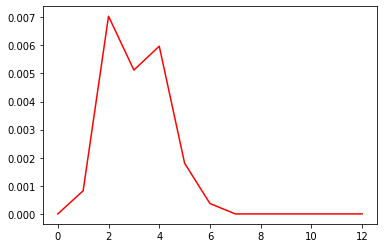

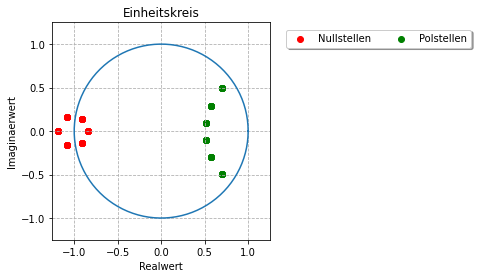

G(s) =  
0.0003405 s^6 + 0.002043 s^5 + 0.005108 s^4 + 0.006811 s^3 + 0.005108 s^2 + 0.002043 s + 0.0003405
--------------------------------------------------------------------------------------------------
             s^6 - 3.579 s^5 + 5.659 s^4 - 4.965 s^3 + 2.529 s^2 - 0.7053 s + 0.08376

Zeitkonstanten =  [-0.95417595+0.66962744j -0.95417595-0.66962744j -1.38441804+0.71123451j
 -1.38441804-0.71123451j -1.87167196+0.35195814j -1.87167196-0.35195814j]
Nullstellen: [-1.19171494+0.j         -1.07941317+0.16549814j -1.07941317-0.16549814j
 -0.90515126+0.1387799j  -0.90515126-0.1387799j  -0.83912685+0.j        ]
Bodediagram:/n
(array([0.00406492, 0.0040645 , 0.00406389, 0.00406301, 0.00406172,
       0.00405984, 0.00405711, 0.00405314, 0.00404738, 0.004039  ,
       0.00402685, 0.00400926, 0.00398388, 0.0039474 , 0.00389526,
       0.00382137, 0.00371793, 0.00357558, 0.00338435, 0.00313586,
       0.00282723, 0.00246588, 0.0020732 , 0.00168259, 0.00133003,
       0.00104099, 0.00082287,

/usr/local/lib/python3.6/dist-packages/control-dev-py3.6.egg/control/freqplot.py:491: FutureWarning: 'Plot' keyword is deprecated in nyquist_plot; use 'plot'


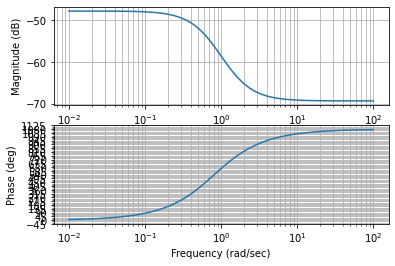

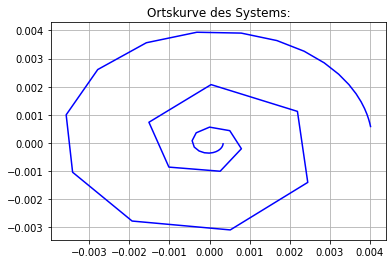

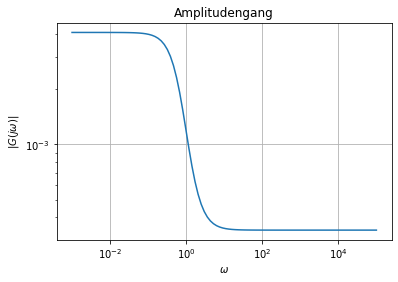

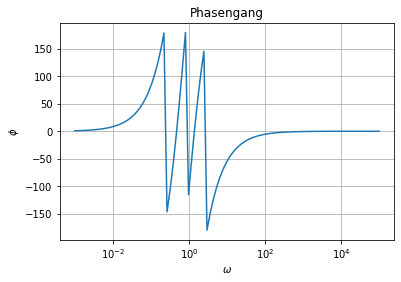

In [5]:
class IIR_sys(object):
    class DelayElement(object):
        uniq_id = int()
        new_input = 0
        output_value = 0
        is_integrated_in_processing_chain = False
        def __init__(self, _passed_id):
            self.uniq_id = _passed_id
        def get_output(self):
            return self.output_value
        def update_input(self, new_value_passed):
            self.new_input = new_value_passed
        def update_output(self, new_value_passed):
            self.output_value = new_value_passed
        def get_processing_flag(self):
            return self.is_integrated_in_processing_chain
        def set_integration_flag(self, passed_flag):           
            self.is_integrated_in_processing_chain = passed_flag
        def get_id(self):
            return self.uniq_id
        def transfer_values(self):
            self.output_value = self.new_input 


    def managing_delay_list(self, passed_input_value):
        temp_value = 0
        if len(self.delay_list) > 0:
            for i in range(len(self.delay_list)):
                if i == 0:
                    self.delay_list[i].update_input(passed_input_value)
                    temp_value = self.delay_list[i].get_output()
                    continue
                self.delay_list[i].update_input(temp_value)
                temp_value = self.delay_list[i].get_output()
            for i in range(len(self.delay_list)):
                self.delay_list[i].transfer_values()
            #debug stuff__________________________________________
#             temp_list = []
#             for i in range(len(self.delay_list)):
#                 temp_entry = self.delay_list[i].get_output()
#                 temp_list.append(temp_entry)
#             print(temp_list)


    def __init__(self, _a_coef_list, _b_coef_list):
        self.a_coef_list = _a_coef_list
        self.N = len(_a_coef_list)
        self.b_coef_list = _b_coef_list
        self.M = len(_b_coef_list)
        self.delay_list = []
        for i in range(self.N):
            created_delay_element = self.DelayElement(i)
            self.delay_list.append(created_delay_element)
        self.H = []
        self.generated_dirac = []
        for i in range(self.M*2-1):
            if i == 0:
                self.generated_dirac.append(1)
            else:
                self.generated_dirac.append(0)
        for i in range(len(self.generated_dirac)):
            entry_timeframe = 0
            #entry_timeframe += self.generated_dirac[i]
            for i_a in range(self.N):
                if i_a == 0:
                    continue
                terget_index_a = i_a - 1
                temp_step1 = self.a_coef_list[i_a]*self.delay_list[terget_index_a].get_output()
                entry_timeframe += temp_step1
            exit_timeframe = 0 
            exit_timeframe += entry_timeframe*self.b_coef_list[0]         
            for i_b in range(self.M):
                if i_b == 0:
                    continue
                terget_index_b = i_b - 1
                temp_step2 = self.delay_list[terget_index_b].get_output()*self.b_coef_list[i_b]
                exit_timeframe += temp_step2
            self.H.append(exit_timeframe)
            #self.delay_list[i].update_output(self.generated_dirac[i])
            self.managing_delay_list(self.generated_dirac[i])
            
    def display_roots(self):
        passed_complex_root_enumerator = np.roots(self.b_coef_list)
        passed_complex_root_denominator = np.roots(self.a_coef_list)
        X_cord_enumerator = [passed_complex_root_enumerator.real for i in passed_complex_root_enumerator]
        Y_cord_enumerator = [passed_complex_root_enumerator.imag for i in passed_complex_root_enumerator]
        X_cord_denominator = [passed_complex_root_denominator.real for i in passed_complex_root_denominator]
        Y_cord_denominator = [passed_complex_root_denominator.imag for i in passed_complex_root_denominator]
        theta = np.linspace(0, 2*np.pi, 100)
        r = np.sqrt(1.0)
        x1 = r*np.cos(theta)
        x2 = r*np.sin(theta)
        fig, ax = plt.subplots(1)
        ax.plot(x1, x2)
        ax.set_aspect(1)
        plt.xlim(-1.25,1.25)
        plt.ylim(-1.25,1.25)
        plt.grid(linestyle='--')
        plt.title('Einheitskreis', fontsize=12)    
        plt.scatter(X_cord_enumerator, Y_cord_enumerator, label='Nullstellen', color='red')
        plt.scatter(X_cord_denominator, Y_cord_denominator, label='Polstellen', color='green')
        #locs = ["upper left", "lower left", "center right", "upper right"]
        #ax.legend(loc=1)
#         red_patch = mpatches.Patch(color='red', label='Nullstellen')
#         green_patch = mpatches.Patch(color='green', label='Polstellen')
        #plt.legend(handles=[red_patch, green_patch])
        plt.legend()
        ax.legend(loc='upper center', bbox_to_anchor=(1.5, 0.99), shadow=True, ncol=2)
        plt.xlabel('Realwert')
        plt.ylabel('Imaginaerwert')
        plt.savefig("Nullstellen_und_Polstellen_01.png", bbox_inches='tight')
        plt.show()

    def system_information(self):
        num  = np.array(self.b_coef_list)
        den  = np.array(self.a_coef_list)
        strecke = tf(num,den)
        print('G(s) = ',strecke)
        print('Zeitkonstanten = ',-1/pole(strecke))
        print('Nullstellen: {}'.format(zero(strecke)))
        print('Bodediagram:/n')
        bb = bode(strecke)
        print(bb)
        real, imag, ww = nyquist(strecke,Plot=False)
        plt.figure()
        plt.plot(real, imag, "b")
        plt.title('Ortskurve des Systems:')
        plt.grid()
        
        plt.figure()
        system = sig.TransferFunction(num, den)
        omega = logspace(-3, 5, 100)
        omega, G = system.freqresp(omega)        
        loglog(omega, absolute(G), '-')
        xlabel('$\omega$')
        ylabel('$|G(j\omega)|$')
        title('Amplitudengang')
        grid(True)
        
        plt.figure()
        semilogx(omega, angle(G, deg = True), '-')
        xlabel('$\omega$')
        ylabel('$\phi$')
        title('Phasengang')
        grid(True)
        


#execution____________________________________________________________________
test_a_coef_list = [1.0, -3.5794348, 5.65866717, -4.96541523, 2.52949491, -0.70527411, 0.08375648]
test_b_coef_list = [0.00034054, 0.00204323, 0.00510806, 0.00681075, 0.00510806, 0.00204323, 0.00034054]
my_sys3 = IIR_sys(test_a_coef_list,test_b_coef_list)
print(my_sys3.H)
print(my_sys3.generated_dirac)
plt.figure()
plt.plot(my_sys3.H, color='red')
#plt.plot(my_sys3.generated_dirac, color='green')
plt.show()
my_sys3.display_roots()
my_sys3.system_information()